In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = pd.read_csv('data/obesity_data_cleaned.csv')
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.0,1.70,81.67,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3,6
1,0,18.0,1.56,57.00,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0,1
2,0,18.0,1.71,50.17,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3,0
3,0,20.0,1.71,131.27,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3,4
4,1,31.0,1.91,93.80,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1,25.0,1.77,114.19,1,1,2.919584,3.000000,2,0,2.151809,0,1.330519,0.196680,1,3,3
20754,1,18.0,1.71,50.00,0,1,3.000000,4.000000,1,0,1.000000,0,2.000000,1.000000,1,3,0
20755,1,20.0,1.82,105.58,1,1,2.407817,3.000000,2,0,2.000000,0,1.158040,1.198439,2,3,3
20756,1,33.0,1.70,83.52,1,1,2.671238,1.971472,2,0,2.144838,0,0.000000,0.973834,2,0,6


In [18]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Chuẩn hóa dữ liệu liên tục bằng Standard Scaler

In [19]:
continuous_vars = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
categorical_vars = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(X[continuous_vars])

X_scaled_continuous_df = pd.DataFrame(X_scaled_continuous, columns=continuous_vars, index=X.index)
X_categorical_df = X[categorical_vars]

X_scaled = pd.concat([X_scaled_continuous_df, X_categorical_df], axis=1)

X_scaled.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
0,0.077086,-0.000969,-0.235711,-0.836279,0.314684,1.206594,-1.171141,0.597438,1,1,1,2,0,0,1,3
1,-0.988500,-1.600728,-1.170931,-0.836279,0.338364,-0.048349,0.021775,0.636513,0,1,1,1,0,0,2,0
2,-0.988500,0.113300,-1.429851,-1.060332,-1.913423,-0.195644,-0.138022,1.755239,0,1,1,2,0,0,2,3
3,-0.633304,0.113300,1.644587,1.039171,0.338364,-0.584035,0.579896,0.271455,0,1,1,2,0,0,1,3
4,1.320270,2.398670,0.224128,0.438397,-1.119801,-0.081469,1.176486,0.523111,1,1,1,2,0,0,1,3


#  PCA và trực quan 

In [24]:
# PCA về 6 chiều
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

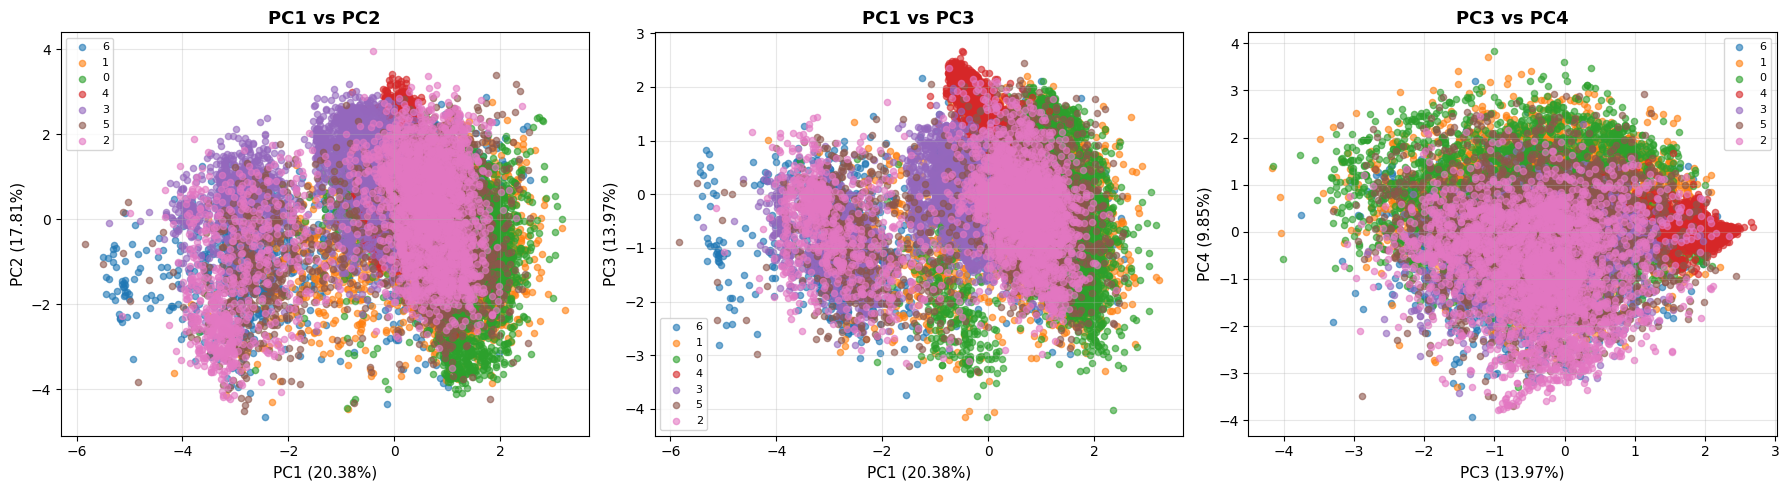

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [(0, 1), (0, 2), (2, 3)]
pair_names = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC3', 'PC4')]

for idx, (i, j) in enumerate(pairs):
    for label in y.unique():
        mask = y == label
        axes[idx].scatter(
            X_pca[mask, i], 
            X_pca[mask, j], 
            label=label,
            alpha=0.6, 
            s=20
        )
    axes[idx].set_xlabel(f'{pair_names[idx][0]} ({pca.explained_variance_ratio_[i]:.2%})', fontsize=11)
    axes[idx].set_ylabel(f'{pair_names[idx][1]} ({pca.explained_variance_ratio_[j]:.2%})', fontsize=11)
    axes[idx].set_title(f'{pair_names[idx][0]} vs {pair_names[idx][1]}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [22]:
print("Tổng phương sai giải thích bởi 6 thành phần chính:")
print(f"{pca.explained_variance_ratio_.sum():.2%}")
print("\nPhương sai giải thích bởi từng thành phần:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.2%}")

Tổng phương sai giải thích bởi 6 thành phần chính:
79.01%

Phương sai giải thích bởi từng thành phần:
PC1: 20.38%
PC2: 17.81%
PC3: 13.97%
PC4: 9.85%
PC5: 9.33%
PC6: 7.67%


# LDA và trực quan

In [27]:
# LDA về 4 chiều
lda = LDA(n_components=4)
X_lda = lda.fit_transform(X_scaled, y)

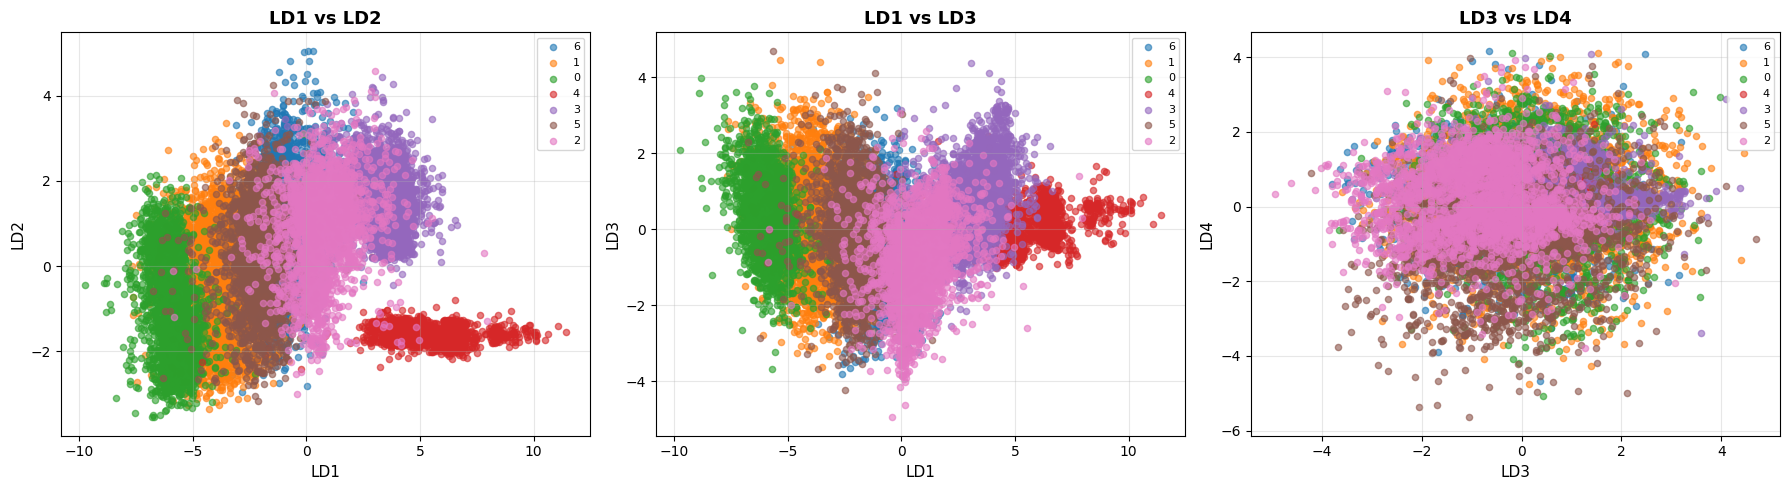

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [(0, 1), (0, 2), (2, 3)]
pair_names = [('LD1', 'LD2'), ('LD1', 'LD3'), ('LD3', 'LD4')]

for idx, (i, j) in enumerate(pairs):
    for label in y.unique():
        mask = y == label
        axes[idx].scatter(
            X_lda[mask, i], 
            X_lda[mask, j], 
            label=label,
            alpha=0.6, 
            s=20
        )
    axes[idx].set_xlabel(f'{pair_names[idx][0]}', fontsize=11)
    axes[idx].set_ylabel(f'{pair_names[idx][1]}', fontsize=11)
    axes[idx].set_title(f'{pair_names[idx][0]} vs {pair_names[idx][1]}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [29]:
print("Tỷ lệ phương sai giải thích bởi từng thành phần LDA:")
for i, var in enumerate(lda.explained_variance_ratio_):
    print(f"LD{i+1}: {var:.2%}")
print(f"\nTổng: {lda.explained_variance_ratio_.sum():.2%}")

Tỷ lệ phương sai giải thích bởi từng thành phần LDA:
LD1: 89.50%
LD2: 7.71%
LD3: 1.67%
LD4: 0.58%

Tổng: 99.46%


# So sánh và đánh giá PCA vs LDA

## 1. Phương sai giải thích
- **PCA**: Giữ lại được phương sai tổng thể của dữ liệu gốc
- **LDA**: Tối đa hóa khả năng phân biệt giữa các lớp, phương sai giải thích thường cao hơn

## 2. Khả năng phân tách lớp
- **PCA**: Các lớp vẫn chồng lấn nhau khá nhiều, không tối ưu cho phân loại
- **LDA**: Các lớp được tách biệt rõ ràng hơn, đặc biệt trên LD1 và LD2

## 3. Ưu điểm

### PCA:
- Không cần nhãn lớp (unsupervised)
- Giảm nhiễu và loại bỏ đa cộng tuyến
- Phù hợp khi chỉ quan tâm đến phương sai dữ liệu

### LDA:
- Tối ưu cho bài toán phân loại (supervised)
- Tách biệt các lớp tốt hơn
- Giảm chiều hiệu quả với ít thành phần hơn

## 4. Nhược điểm

### PCA:
- Không sử dụng thông tin nhãn
- Có thể mất thông tin quan trọng cho phân loại

### LDA:
- Cần có nhãn lớp
- Số chiều tối đa = số lớp - 1 (trong trường hợp này là 6)
- Giả định phân phối chuẩn và ma trận hiệp phương sai đồng nhất

## 5. Kết luận
Với bài toán dự đoán béo phì (7 lớp), **LDA phù hợp hơn** vì:
- Mục tiêu chính là phân loại
- Có sẵn nhãn lớp
- LDA tạo ra không gian đặc trưng tách biệt các lớp rõ ràng hơn
- Cần ít thành phần hơn để đạt hiệu quả phân loại tốt
